# Helper Function

In [74]:
%run D:/Code/py_code/Convolutional-Neural-Network/experiment/widi/helper_func.py

from helper_func import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, make_confusion_matrix, load_and_prep_image

# Inspect the Data

In [43]:
walk_through_dir("D:\Code\py_code\Convolutional-Neural-Network\data")

There are 2 directories and 0 images in 'D:\Code\py_code\Convolutional-Neural-Network\data'.
There are 3 directories and 0 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\test'.
There are 0 directories and 213 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\test\angry'.
There are 0 directories and 207 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\test\happy'.
There are 0 directories and 149 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\test\sad'.
There are 3 directories and 0 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\train'.
There are 0 directories and 850 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\train\angry'.
There are 0 directories and 830 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\train\happy'.
There are 0 directories and 598 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\train\sad'.


In [44]:
train_dir = r"D:\Code\py_code\Convolutional-Neural-Network\data\train"
test_dir = r"D:\Code\py_code\Convolutional-Neural-Network\data\test"

# Preprocessing the Data

In [45]:
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                color_mode = "rgb",
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                color_mode = "rgb",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) 

Found 2278 files belonging to 3 classes.
Found 569 files belonging to 3 classes.


In [46]:
train_data.class_names

['angry', 'happy', 'sad']

In [47]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpointt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, 
                                                         monitor="val_accuracy", 
                                                         save_best_only=True)

In [48]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  preprocessing.Rescaling(1./255)
], name ="data_augmentation")

In [49]:
base_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) 
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) 
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x) 
model = tf.keras.Model(inputs, outputs)

In [50]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048   21802784  
                             )                                   
                                                                 
 global_average_pooling (Gl  (None, 2048)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 3)                 6147      
                                                           

In [51]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), 
                                           callbacks=[checkpoint_callback])

Epoch 1/5


72/72 [==============================] - 77s 1s/step - loss: 1.0767 - accuracy: 0.4737 - val_loss: 1.1185 - val_accuracy: 0.2656
Epoch 2/5
72/72 [==============================] - 78s 1s/step - loss: 0.9104 - accuracy: 0.5663 - val_loss: 1.2067 - val_accuracy: 0.2344
Epoch 3/5
72/72 [==============================] - 76s 1s/step - loss: 0.8784 - accuracy: 0.5856 - val_loss: 0.9013 - val_accuracy: 0.4688
Epoch 4/5
72/72 [==============================] - 82s 1s/step - loss: 0.8500 - accuracy: 0.6128 - val_loss: 0.9694 - val_accuracy: 0.4531
Epoch 5/5
72/72 [==============================] - 77s 1s/step - loss: 0.8032 - accuracy: 0.6506 - val_loss: 0.9873 - val_accuracy: 0.4375


In [52]:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

18/18 [==============================] - 18s 968ms/step - loss: 0.8312 - accuracy: 0.6327


[0.8312145471572876, 0.6326889395713806]

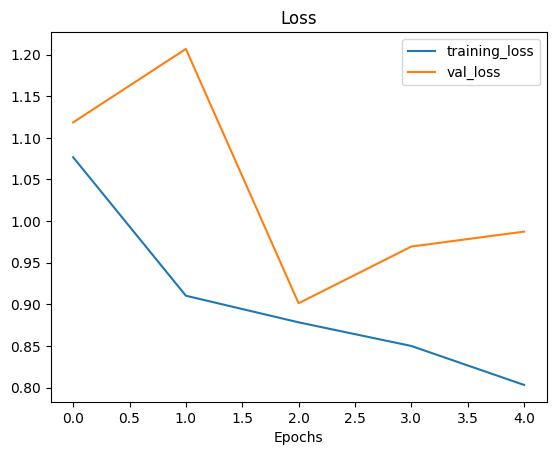

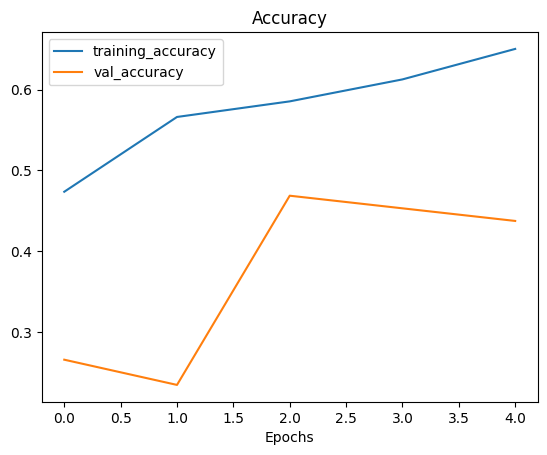

In [53]:
plot_loss_curves(history_all_classes_10_percent)

# Fine tunning

In [54]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [55]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [56]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
inception_v3 True
global_average_pooling True
output_layer True


In [57]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 conv2d_188 False
2 batch_normalization_188 False
3 activation_188 False
4 conv2d_189 False
5 batch_normalization_189 False
6 activation_189 False
7 conv2d_190 False
8 batch_normalization_190 False
9 activation_190 False
10 max_pooling2d_8 False
11 conv2d_191 False
12 batch_normalization_191 False
13 activation_191 False
14 conv2d_192 False
15 batch_normalization_192 False
16 activation_192 False
17 max_pooling2d_9 False
18 conv2d_196 False
19 batch_normalization_196 False
20 activation_196 False
21 conv2d_194 False
22 conv2d_197 False
23 batch_normalization_194 False
24 batch_normalization_197 False
25 activation_194 False
26 activation_197 False
27 average_pooling2d_18 False
28 conv2d_193 False
29 conv2d_195 False
30 conv2d_198 False
31 conv2d_199 False
32 batch_normalization_193 False
33 batch_normalization_195 False
34 batch_normalization_198 False
35 batch_normalization_199 False
36 activation_193 False
37 activation_195 False
38 activation_198 False
39 activation

In [58]:
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
72/72 [==============================] - 84s 1s/step - loss: 0.7551 - accuracy: 0.6883 - val_loss: 0.8964 - val_accuracy: 0.5469
Epoch 6/10
72/72 [==============================] - 79s 1s/step - loss: 0.7709 - accuracy: 0.6589 - val_loss: 1.0218 - val_accuracy: 0.4375
Epoch 7/10
72/72 [==============================] - 81s 1s/step - loss: 0.7561 - accuracy: 0.6778 - val_loss: 0.8476 - val_accuracy: 0.5781
Epoch 8/10
72/72 [==============================] - 1393s 20s/step - loss: 0.7679 - accuracy: 0.6760 - val_loss: 0.8692 - val_accuracy: 0.5781
Epoch 9/10
72/72 [==============================] - 49s 676ms/step - loss: 0.7628 - accuracy: 0.6782 - val_loss: 0.9084 - val_accuracy: 0.5312
Epoch 10/10
72/72 [==============================] - 70s 968ms/step - loss: 0.7511 - accuracy: 0.6765 - val_loss: 0.8901 - val_accuracy: 0.5312


In [59]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

18/18 [==============================] - 15s 813ms/step - loss: 0.8175 - accuracy: 0.6292


[0.8175336122512817, 0.629173994064331]

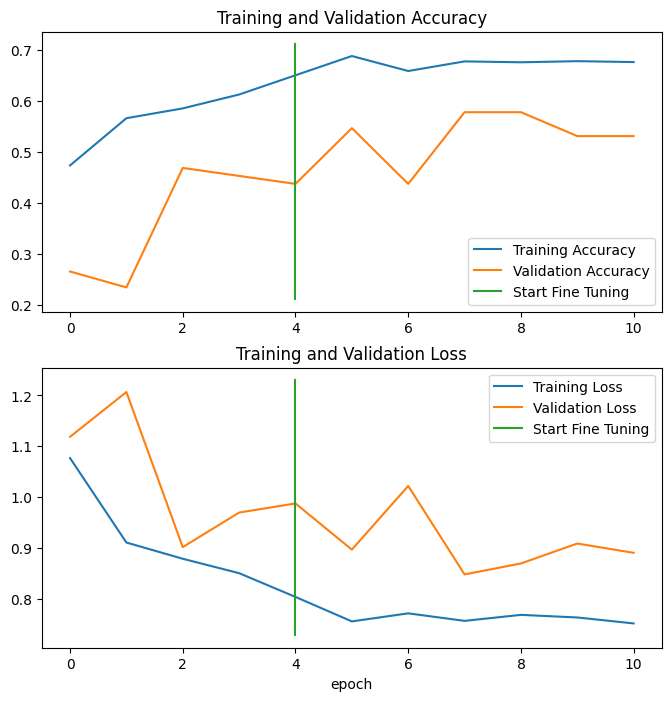

In [60]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

In [61]:
pred_probs = model.predict(test_data, verbose=1)
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

18/18 [==============================] - 16s 811ms/step


array([0, 2, 0, 2, 0, 0, 0, 0, 0, 0], dtype=int64)

In [62]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Evaluating the Model

In [63]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6291739894551845

In [64]:
# Get the class names
class_names = test_data.class_names
class_names[:10]

['angry', 'happy', 'sad']

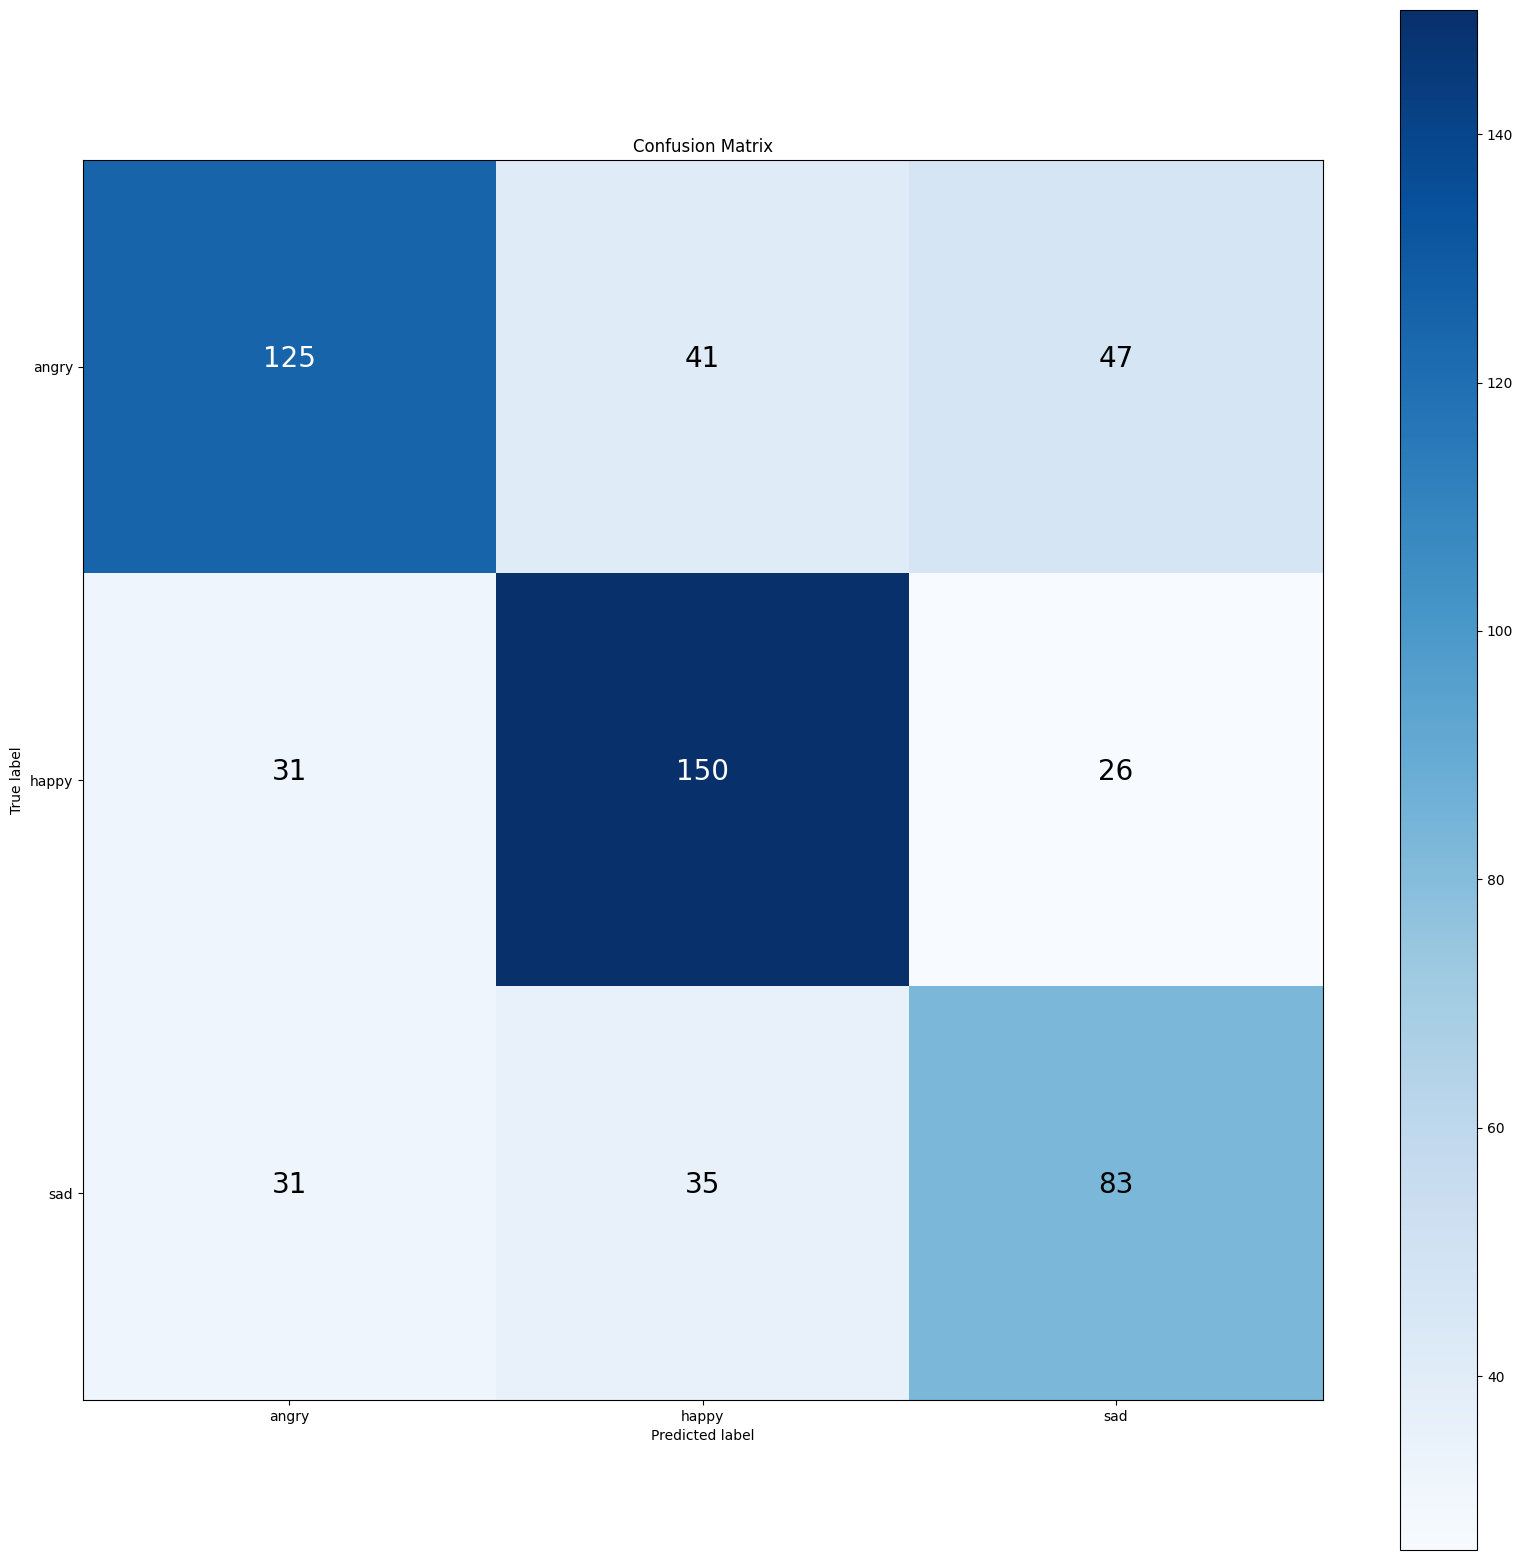

In [68]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(20, 20),
                      text_size=20,
                      norm=False, 
                      savefig=True)

In [66]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.67      0.59      0.62       213
           1       0.66      0.72      0.69       207
           2       0.53      0.56      0.54       149

    accuracy                           0.63       569
   macro avg       0.62      0.62      0.62       569
weighted avg       0.63      0.63      0.63       569



In [69]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.6684491978609626,
  'recall': 0.5868544600938967,
  'f1-score': 0.625,
  'support': 213},
 '1': {'precision': 0.6637168141592921,
  'recall': 0.7246376811594203,
  'f1-score': 0.6928406466512702,
  'support': 207},
 '2': {'precision': 0.532051282051282,
  'recall': 0.5570469798657718,
  'f1-score': 0.5442622950819672,
  'support': 149},
 'accuracy': 0.6291739894551845,
 'macro avg': {'precision': 0.6214057646905121,
  'recall': 0.6228463737063629,
  'f1-score': 0.6207009805777458,
  'support': 569},
 'weighted avg': {'precision': 0.6310100188066774,
  'recall': 0.6291739894551845,
  'f1-score': 0.6285379539965308,
  'support': 569}}

In [70]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'angry': 0.625, 'happy': 0.6928406466512702, 'sad': 0.5442622950819672}

In [71]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

,class_name,f1-score
1,happy,0.692841
0,angry,0.625000
2,sad,0.544262


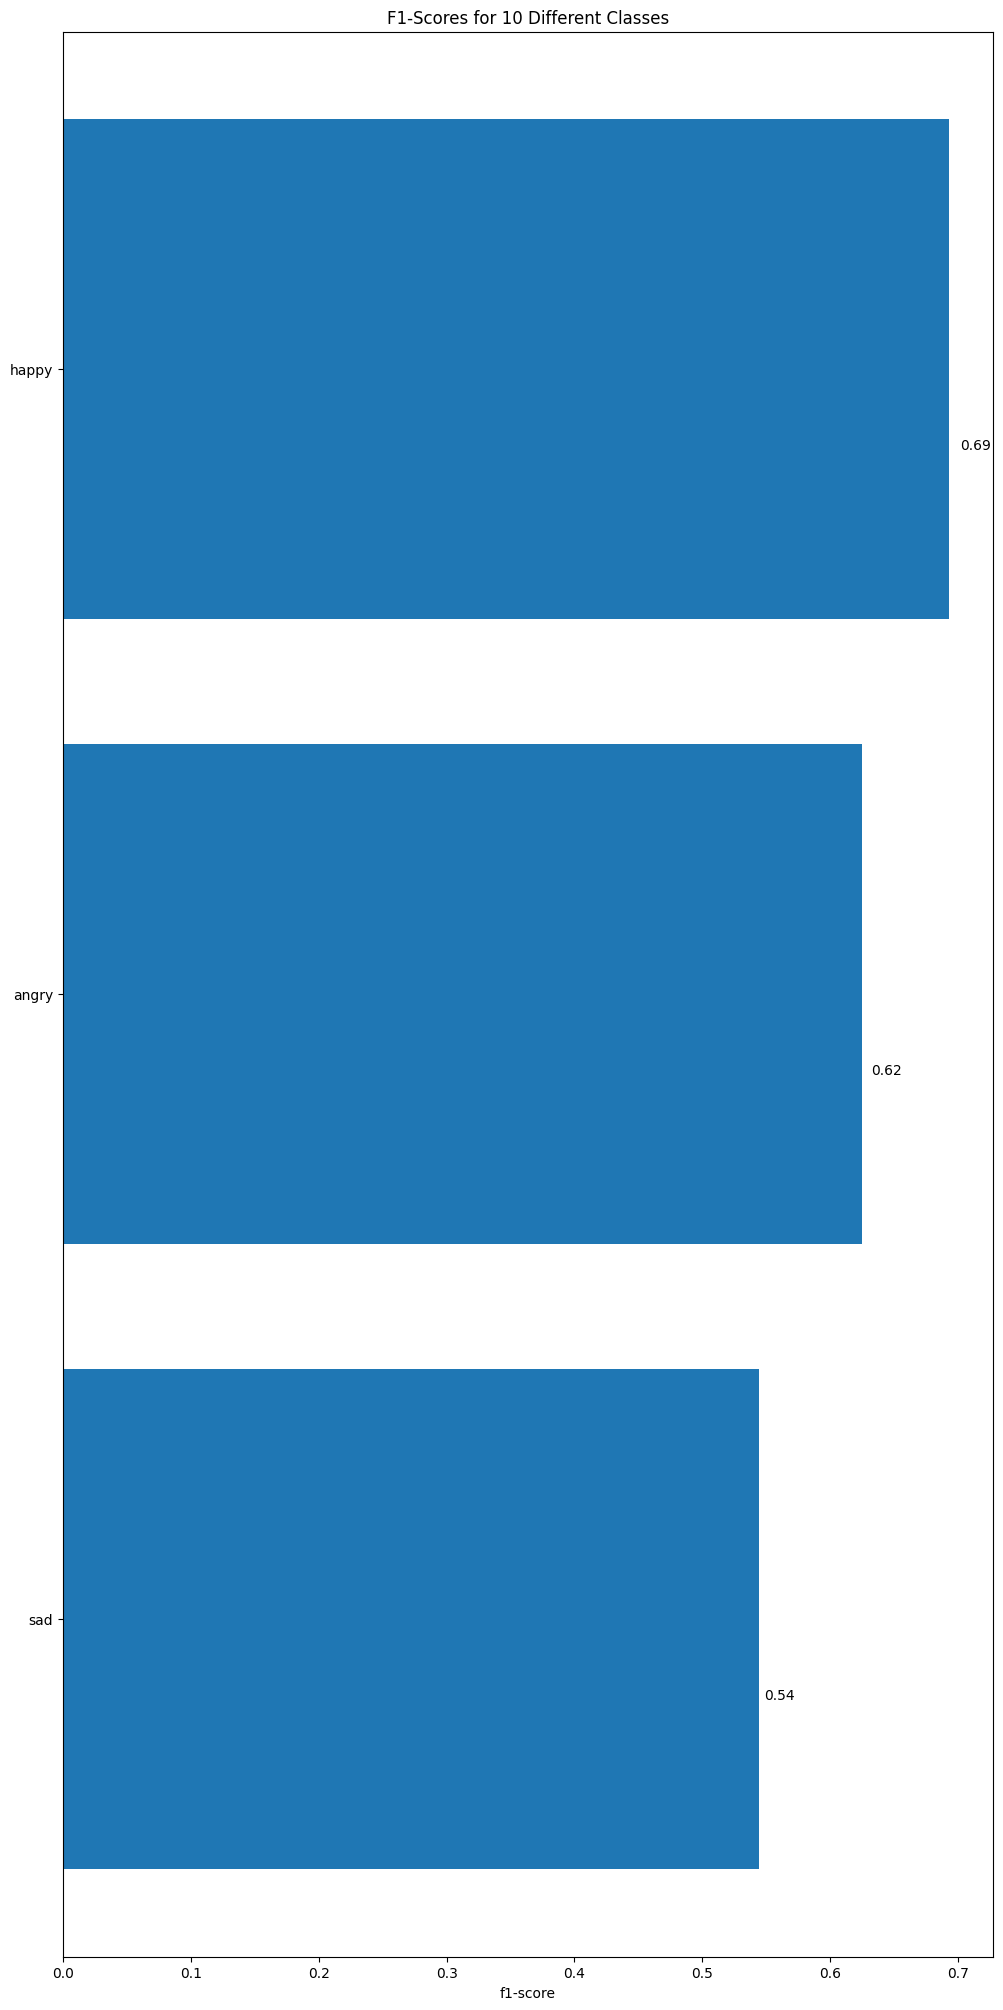

In [72]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

# Predict on an image

1/1 [==============================] - 0s 171ms/step


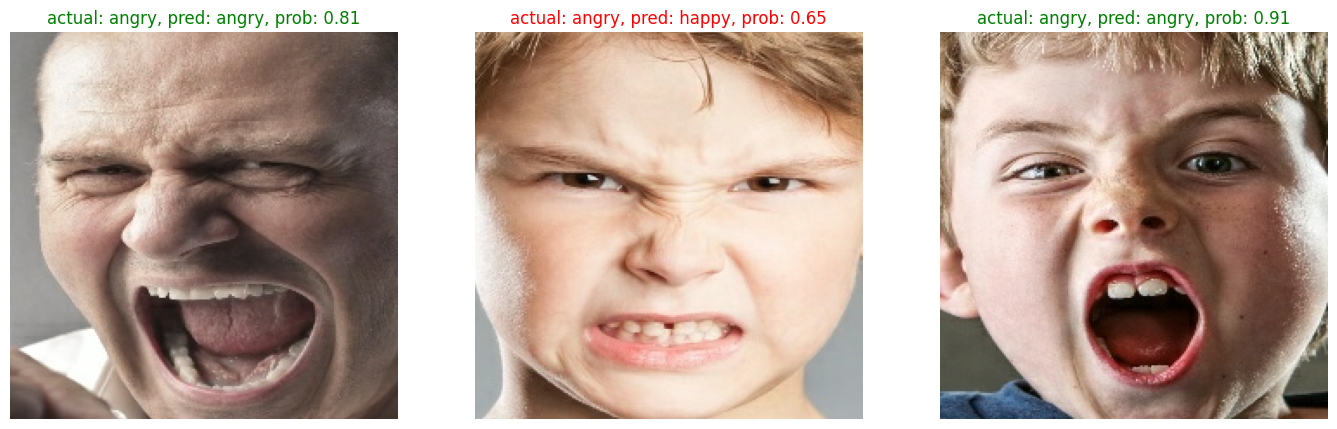

In [77]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + "/" + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

# Get most Wrong

In [80]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files(r"D:\Code\py_code\Convolutional-Neural-Network\data\test\*\*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'D:\\Code\\py_code\\Convolutional-Neural-Network\\data\\test\\angry\\1.jpg',
 b'D:\\Code\\py_code\\Convolutional-Neural-Network\\data\\test\\angry\\101.jpg',
 b'D:\\Code\\py_code\\Convolutional-Neural-Network\\data\\test\\angry\\1012.jpg',
 b'D:\\Code\\py_code\\Convolutional-Neural-Network\\data\\test\\angry\\1016.jpg',
 b'D:\\Code\\py_code\\Convolutional-Neural-Network\\data\\test\\angry\\1018.jpg',
 b'D:\\Code\\py_code\\Convolutional-Neural-Network\\data\\test\\angry\\102.jpg',
 b'D:\\Code\\py_code\\Convolutional-Neural-Network\\data\\test\\angry\\1025.jpg',
 b'D:\\Code\\py_code\\Convolutional-Neural-Network\\data\\test\\angry\\1028.jpg',
 b'D:\\Code\\py_code\\Convolutional-Neural-Network\\data\\test\\angry\\103.jpg',
 b'D:\\Code\\py_code\\Convolutional-Neural-Network\\data\\test\\angry\\1030.jpg']

In [81]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'D:\\Code\\py_code\\Convolutional-Neural-Netw...,0,0,0.542957,angry,angry
1,b'D:\\Code\\py_code\\Convolutional-Neural-Netw...,0,2,0.391256,angry,sad
2,b'D:\\Code\\py_code\\Convolutional-Neural-Netw...,0,0,0.584417,angry,angry
3,b'D:\\Code\\py_code\\Convolutional-Neural-Netw...,0,2,0.726587,angry,sad
4,b'D:\\Code\\py_code\\Convolutional-Neural-Netw...,0,0,0.515944,angry,angry


In [82]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'D:\\Code\\py_code\\Convolutional-Neural-Netw...,0,0,0.542957,angry,angry,True
1,b'D:\\Code\\py_code\\Convolutional-Neural-Netw...,0,2,0.391256,angry,sad,False
2,b'D:\\Code\\py_code\\Convolutional-Neural-Netw...,0,0,0.584417,angry,angry,True
3,b'D:\\Code\\py_code\\Convolutional-Neural-Netw...,0,2,0.726587,angry,sad,False
4,b'D:\\Code\\py_code\\Convolutional-Neural-Netw...,0,0,0.515944,angry,angry,True


In [83]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
293,b'D:\\Code\\py_code\\Convolutional-Neural-Netw...,1,0,0.951673,happy,angry,False
185,b'D:\\Code\\py_code\\Convolutional-Neural-Netw...,0,2,0.909088,angry,sad,False
290,b'D:\\Code\\py_code\\Convolutional-Neural-Netw...,1,2,0.886717,happy,sad,False
420,b'D:\\Code\\py_code\\Convolutional-Neural-Netw...,2,1,0.876579,sad,happy,False
51,b'D:\\Code\\py_code\\Convolutional-Neural-Netw...,0,2,0.868685,angry,sad,False
88,b'D:\\Code\\py_code\\Convolutional-Neural-Netw...,0,1,0.838754,angry,happy,False
442,b'D:\\Code\\py_code\\Convolutional-Neural-Netw...,2,1,0.832737,sad,happy,False
149,b'D:\\Code\\py_code\\Convolutional-Neural-Netw...,0,1,0.820935,angry,happy,False
349,b'D:\\Code\\py_code\\Convolutional-Neural-Netw...,1,0,0.809011,happy,angry,False
40,b'D:\\Code\\py_code\\Convolutional-Neural-Netw...,0,2,0.801135,angry,sad,False


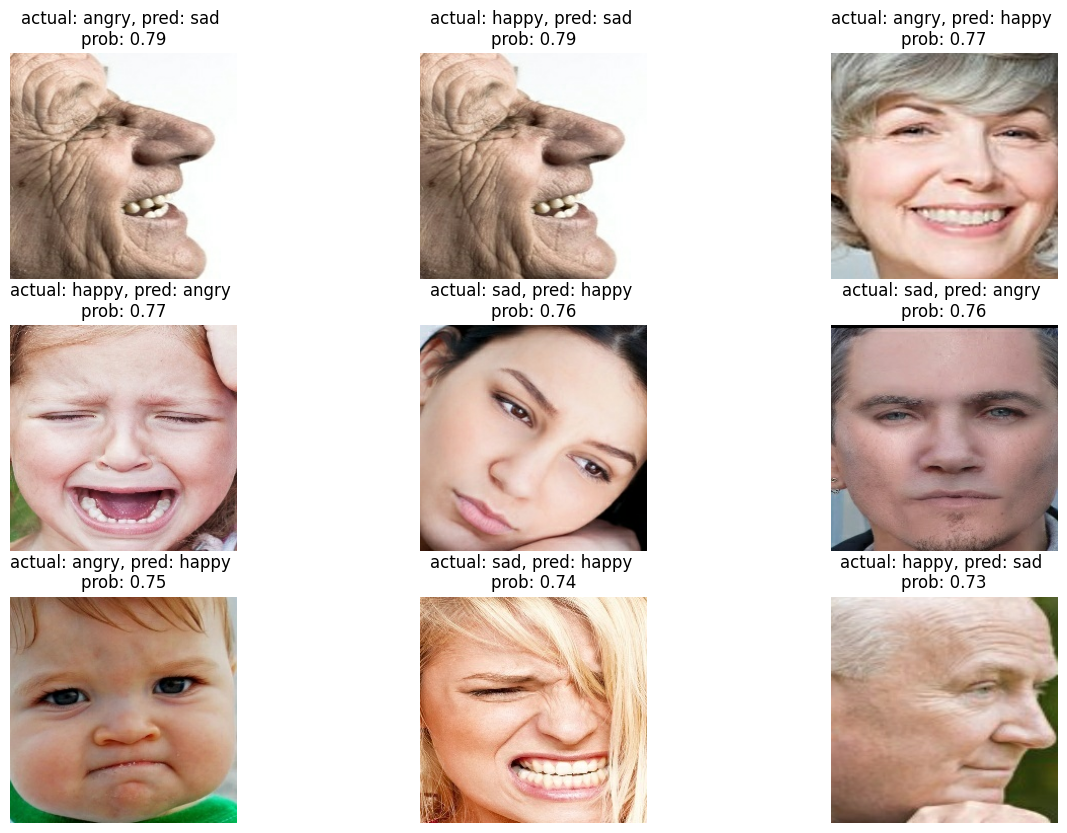

In [85]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)